<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 4: Build a Convolution Neural Network

</div>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-10-30 05:55:32--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   108MB/s    in 0.6s    

2023-10-30 05:55:32 (108 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-10-30 05:55:32--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## A. Data Loading and Preprocessing

In Convolutional Neural Networks (CNNs), the convolution operation expects the input to have a specific shape, typically denoted as `[batch_size, channels, height, width]`. The "channels" dimension refers to the number of input channels (or depth) of the input data.

For standard RGB images, this channels value is 3 (for red, green, and blue). For grayscale images, there's only one channel. For more specialized data, there could be more channels. For example, medical imaging modalities like MRI or CT can sometimes have multiple channels representing different types of scans or different views of the same scan.

When working with data that doesn't naturally have a channels dimension (e.g., plain grayscale image arrays that are just `[height, width]`), you need to explicitly add a channels dimension to match the expected input format of the CNN. This is done using `.unsqueeze(1)` which adds an additional dimension at the 1st position (0-indexed), converting a shape like `[batch_size, height, width]` to `[batch_size, 1, height, width]`. The "1" here indicates a single channel.


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float().unsqueeze(1)
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks

### 1. Use the **Class**

In PyTorch, we define our custom neural network architectures by subclassing the `nn.Module` class. This gives our neural network all the functionality it needs to work with PyTorch's other utilities and keeps our implementation organized.

- Neural networks are defined by subclassing `nn.Module`.
- The layers of the neural network are initialized in the `__init__` method.
- The forward pass operations on input data are defined in the `forward` method.

It's worth noting that while we only define the forward pass, PyTorch will automatically derive the backward pass for us, which is used during training to update the model's weights."

```python
import torch.nn as nn
import torch.nn.functional as F

# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 32), # 1st FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 2nd FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 3rd FC
#     nn.ReLU(),
#     nn.Linear(32, 1)          # 4th FC
# ).cuda()

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*256*1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

model = LinearModel()
print(model)
```

```
LinearModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
```

### 2. ann2cnn

To transition a model from an ANN to a CNN using `nn.Conv2d` layers, we make the following changes:

- Replace `nn.Linear` layers with `nn.Conv2d` layers for the initial layers.
- Add pooling layers after convolutional layers for spatial dimension reduction.
- Introduce a flattening step before transitioning to fully connected layers.
- Adjust the `forward` method to handle the convolutional and pooling operations and reshaping.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 256*256
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128*128

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class ConvGAP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same') ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128*128
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 128*128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 64*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1)
        )

    def forward(self, x):

        x = self.net(x)
        return x

In [6]:
class ConvModel_dropout(nn.Module):
    def __init__(self, probability=0.5):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 256*256
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128*128

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(probability)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
class ConvGAPWithDropout(nn.Module):
    def __init__(self, probability=0.5):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(probability),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128*128

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(probability),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64*64

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(probability),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32*32

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.net(x)
        return x


In [8]:
class LinearModel(nn.Module):
    def __init__(self, input_dim=65536):
        super(LinearModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
class LinearModelWithDropout(nn.Module):
    def __init__(self, input_dim=65536, dropout_probability=0.5):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 1)

        self.dropout = nn.Dropout(p=dropout_probability)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = self.fc4(x)

        return x

In [10]:
import os
import json
import torch
import matplotlib.pyplot as plt

class ModelData():

    def __init__(self, name, dataset_name):
        ''' 使用範例:
            md_data = ModelData(name="Model", dataset_name=[""])
            md_data.model_path="/content/drive"
            md_data.add_data(epoch=0, loss=0.5)
            md_data.reset_data(time=str(datetime.datetime.now()))
            md_data.save_data()
        '''
        self.model_data_dic = {}
        self.reset_data(name=name, dataset_name=dataset_name)
        self.model_path = "."

    def reset_path_and_folder(self, model_path):
        os.makedirs(model_path, exist_ok=True)
        self.model_path = model_path

    def reset_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)  # 設置實例的屬性
            self.model_data_dic[kwarg] = value  # 更新 self.model_data_dic 字典

    def add_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)
            if kwarg in self.model_data_dic and isinstance(self.model_data_dic[kwarg], list):
                self.model_data_dic[kwarg].append(value)
            else:
                self.model_data_dic[kwarg] = [value]

    def save_data(self, path=None, name=None):
        if path is None:
            path = self.model_path
        if name is None:
            name = self.name

        # 確保目錄存在，如果不存在則創建
        os.makedirs(path, exist_ok=True)

        file_path = f"{path}/{name}.json"
        existing_model_list = []

        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                existing_model_list = json.load(f)

        existing_model_list.append(self.model_data_dic)

        with open(file_path, 'w') as f:
            json.dump(existing_model_list, f, indent=4)

        print(f"Successfully dumped data into {file_path}")

    def read_data(self, model_name_list, model_root_path, mode="wm"):
        existing_model_list = []
        weight_list = []

        for name in model_name_list:
            if not name:  # Skip empty names
                continue

            file_path = f"{model_root_path}/{name}/{name}.json"  # 使用 model_root_path
            weight_path = f"{model_root_path}/{name}/{name}.pth"  # 使用 model_root_path

            print(f"Trying to read JSON from: {file_path}")  # 調試信息
            print(f"Trying to read weights from: {weight_path}")  # 調試信息

            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    existing_model_list.append(json.load(f))
            else:
                print(f"File {file_path} does not exist.")

            if os.path.exists(weight_path):
                weight_list.append(torch.load(weight_path))
            else:
                print(f"Weight file {weight_path} does not exist.")

        if mode == "w":
            return weight_list
        if mode == "m":
            return existing_model_list
        else:
            return weight_list, existing_model_list

    def compare_images(self, existing_model_list):
        for model_data in existing_model_list:
            for each_model_data in model_data:
                fig, ax = plt.subplots(1, 2, figsize=(15, 5))

                # Plotting training and validation accuracy
                ax[0].plot(each_model_data["train_accuracies"])
                ax[0].plot(each_model_data["val_accuracies"])
                ax[0].set_title(f'{each_model_data["name"]} Accuracy')
                ax[0].set_xlabel('Epochs')
                ax[0].set_ylabel('Accuracy')
                ax[0].legend(['Train', 'Val'])

                # Plotting training and validation loss
                ax[1].plot(each_model_data["train_losses"])
                ax[1].plot(each_model_data["val_losses"])
                ax[1].set_title(f'{each_model_data["name"]} Loss')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Loss')
                ax[1].legend(['Train', 'Val'])

                plt.show()

    def change_data(self, data_path, key, value):
        if os.path.exists(data_path):
            # 讀取現有的數據
            with open(data_path, 'r') as f:
                total_data = json.load(f)

            # 修改數據
            for i in total_data:
                i[key] = value

            # 寫回文件
            with open(data_path, 'w') as f:
                json.dump(total_data, f, indent=4)

In [11]:
md_data = ModelData(name="Test", dataset_name=["https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy","https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy"])
md_data.reset_path_and_folder(f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/{md_data.name}")
# md_data.add_data(epoch=0, loss=0.5)
# md_data.reset_data(test_accuracy=0.8)
# md_data.save_data()

import datetime
traning_times = []
# training_time = datetime.datetime.now()
# traning_times.appened(training_time)

## C. Training the Neural Network

`model = model.cuda()` moves the model's parameters and buffers to the GPU memory.

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 3

# Change you model here
model = LinearModel()

print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'{md_data.model_path}/{md_data.name}.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    training_time = str(datetime.datetime.now())
    traning_times.append(training_time)

LinearModel(
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3, Train loss: 0.5464, Train acc: 74.25%, Val loss: 0.3694, Val acc: 83.00%, Best Val loss: 0.3694 Best Val acc: 83.00%
Epoch 2/3, Train loss: 0.2974, Train acc: 87.12%, Val loss: 0.2687, Val acc: 88.50%, Best Val loss: 0.2687 Best Val acc: 88.50%
Epoch 3/3, Train loss: 0.2646, Train acc: 88.88%, Val loss: 0.3622, Val acc: 85.25%, Best Val loss: 0.2687 Best Val acc: 88.50%


### Visualizing model performance

## D. Evaluating Your Trained Model

In [13]:
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-10-30 05:56:13--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107328 (12M) [application/octet-stream]
Saving to: ‘test_normal.npy’

test_normal.npy     100%[===================>]  12.50M  --.-KB/s    in 0.1s    

2023-10-30 05:56:14 (121 MB/s) - ‘test_normal.npy’ saved [13107328/13107328]

--2023-10-30 05:56:14--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

### Process Test Dataset

In [14]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1)
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


### Load Trained Model and Evaluate

In [15]:
test_correct = 0
test_total = 0

# Declare the model architecture
model = LinearModel()
print(model)
model = model.cuda()

# Load the trained weights
model.load_state_dict(torch.load(f'{md_data.model_path}/{md_data.name}.pth'))

# Set the model to evaluation mode
model.eval()
total_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        outputs = model(images)
        labels = labels.float().unsqueeze(1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted.float() == labels).sum().item()
        total += labels.size(0)

test_avg_loss = total_loss / len(test_loader)
test_accuracy = 100. * correct / total

print(f'test_avg_loss: {test_avg_loss}')
print(f'Test accuracy is {test_accuracy}%.')

LinearModel(
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
test_avg_loss: 0.35864011026345766
Test accuracy is 84.25%.


In [18]:
def change_data(data_path, key, value):
    if os.path.exists(data_path):
        # 讀取現有的數據
        with open(data_path, 'r') as f:
            total_data = json.load(f)
        # 修改數據
        for i in total_data:
            i[key] = value
        # 寫回文件
        with open(data_path, 'w') as f:
            json.dump(total_data, f, indent=4)

def retest(name, model, model_path):

    test_correct = 0
    test_total = 0

    # Declare the model architecture
    model = model
    # print(model)
    model = model.cuda()

    # Load the trained weights
    model.load_state_dict(torch.load(f'{model_path}/{name}/{name}.pth'))

    # Set the model to evaluation mode
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            labels = labels.float().unsqueeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    test_avg_loss = total_loss / len(val_loader)
    test_accuracy = 100. * correct / total

    print(f'{name} test_avg_loss: {test_avg_loss}')
    print(f'{name} Test accuracy is {test_accuracy}%.')

    change_data(f'{model_path}/{name}/{name}.json', "test_avg_loss", test_avg_loss)
    change_data(f'{model_path}/{name}/{name}.json', "test_accuracy", test_accuracy)

model_path = f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model"

model_name_list = ['ConvModel_oringinal', "ConvModel_dropout_0.5", "ConvModel_dropout_0.75", "ConvModel_dropout_0.25",
                   'ConvGAP_oringinal', "ConvGAPWithDropout_0.75", "ConvGAPWithDropout_0.5", "ConvGAPWithDropout_0.25",
                   "ConvGAP_but_longer", "ConvGAPWithDropout_0.75_but_longer",
                   'LinearModel', "LinearModelWithDropout"]
model_list = [ConvModel(), ConvModel_dropout(), ConvModel_dropout(), ConvModel_dropout(),
              ConvGAP(), ConvGAPWithDropout(), ConvGAPWithDropout(), ConvGAPWithDropout(),
              ConvGAP(), ConvGAPWithDropout(),
              LinearModel(), LinearModelWithDropout()]

# 使用 enumerate 同時獲得索引和元素
for i, model_name in enumerate(model_name_list):
    retest(model_name, model_list[i], model_path)

ConvModel_oringinal test_avg_loss: 1.545087941609941
ConvModel_oringinal Test accuracy is 73.0%.
ConvModel_dropout_0.5 test_avg_loss: 1.0196890723175154
ConvModel_dropout_0.5 Test accuracy is 77.75%.
ConvModel_dropout_0.75 test_avg_loss: 0.6937624929616084
ConvModel_dropout_0.75 Test accuracy is 80.0%.
ConvModel_dropout_0.25 test_avg_loss: 0.8703779285200514
ConvModel_dropout_0.25 Test accuracy is 78.5%.
ConvGAP_oringinal test_avg_loss: 0.5534441769123077
ConvGAP_oringinal Test accuracy is 74.5%.
ConvGAPWithDropout_0.75 test_avg_loss: 0.679476444537823
ConvGAPWithDropout_0.75 Test accuracy is 55.0%.
ConvGAPWithDropout_0.5 test_avg_loss: 0.6211868387002212
ConvGAPWithDropout_0.5 Test accuracy is 67.25%.
ConvGAPWithDropout_0.25 test_avg_loss: 0.5401322039274069
ConvGAPWithDropout_0.25 Test accuracy is 77.25%.
ConvGAP_but_longer test_avg_loss: 0.4997557057784154
ConvGAP_but_longer Test accuracy is 77.0%.
ConvGAPWithDropout_0.75_but_longer test_avg_loss: 0.6574387275255643
ConvGAPWithDropo

In [ ]:
md_data.reset_data(train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies, traning_times=traning_times)
md_data.reset_data(model=str(model))
md_data.reset_data(test_data=["https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy","https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy"])
md_data.reset_data(test_avg_loss=test_avg_loss, test_accuracy=test_accuracy)
md_data.save_data()

Successfully dumped data into /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/LinearModel/LinearModel.json


In [ ]:
md_data.model_data_dic

{'name': 'ConvGAPWithDropout_0.75_but_longer',
 'dataset_name': ['https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy',
  'https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy'],
 'train_losses': [0.6950026857852936,
  0.6765194261074066,
  0.6449680435657501,
  0.620541387796402,
  0.5976860618591309,
  0.582926235795021,
  0.5880345231294632,
  0.5649960571527481,
  0.5635753464698792,
  0.5523709690570832,
  0.5289756554365158,
  0.524159989953041,
  0.5229360586404801,
  0.519802628159523,
  0.516489247083664,
  0.514218978881836,
  0.5099841165542602,
  0.5098951345682144,
  0.5017824018001557,
  0.5048726153373718,
  0.4964506858587265,
  0.4945106428861618,
  0.49442811250686647,
  0.49448957443237307,
  0.49328559398651123,
  0.49403874278068544,
  0.4919991648197174,
  0.49200976550579073,
  0.4919169372320175,
  0.49131301522254944,
  0.4911169755458832,
  0.4905818408727646,
  0.4908341300487518,
  0.490736903

Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_oringinal/ConvModel_oringinal.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_oringinal/ConvModel_oringinal.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_dropout_0.5/ConvModel_dropout_0.5.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_dropout_0.5/ConvModel_dropout_0.5.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_dropout_0.75/ConvModel_dropout_0.75.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_dropout_0.75/ConvModel_dropout_0.75.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_dropout_0.25/ConvModel_dropout_0.25.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model/ConvModel_dropout_

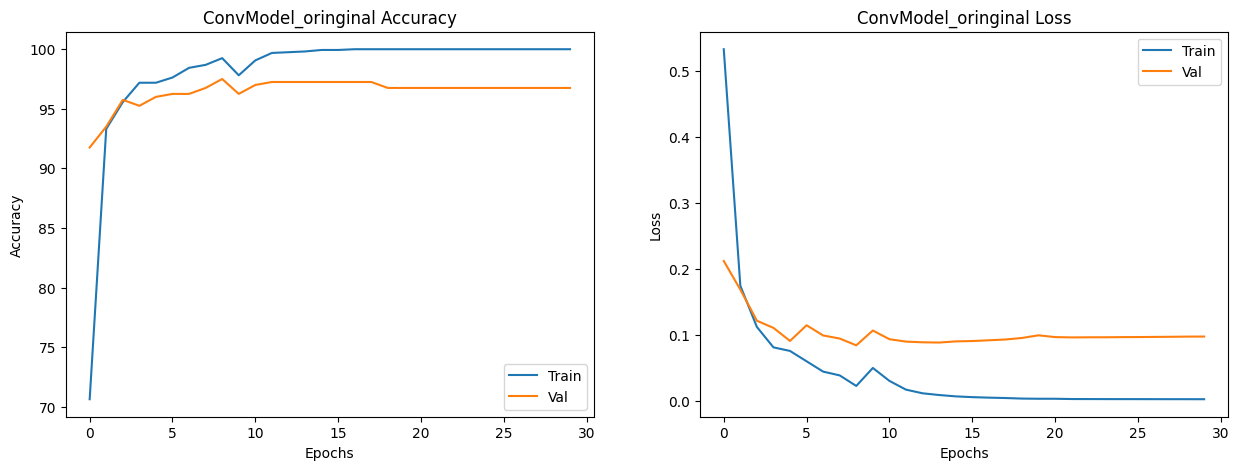

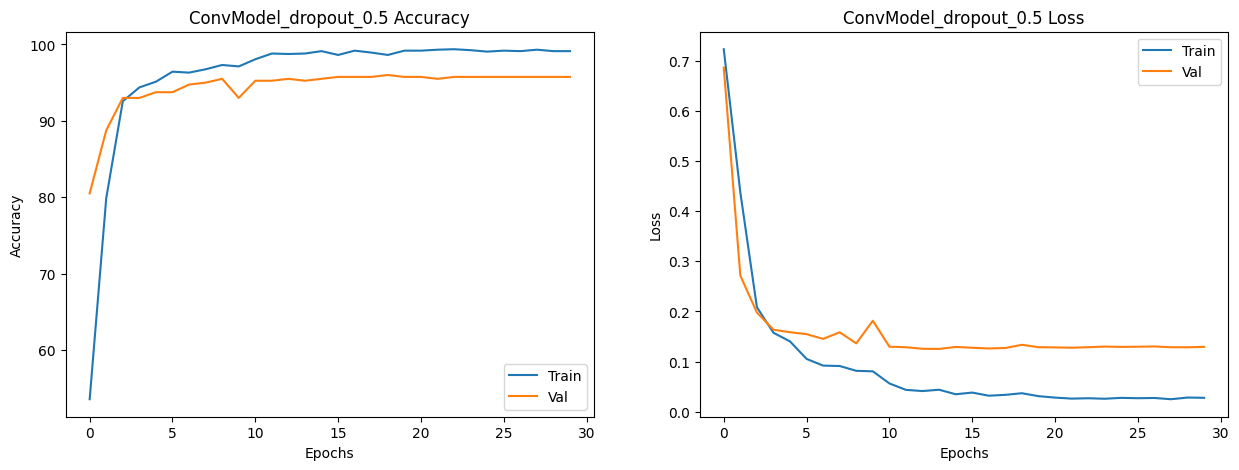

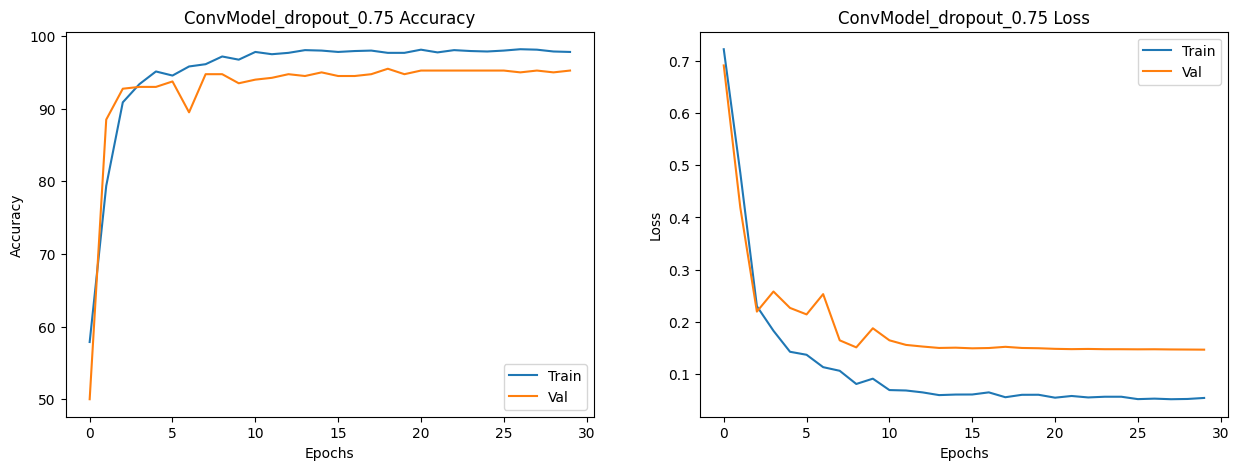

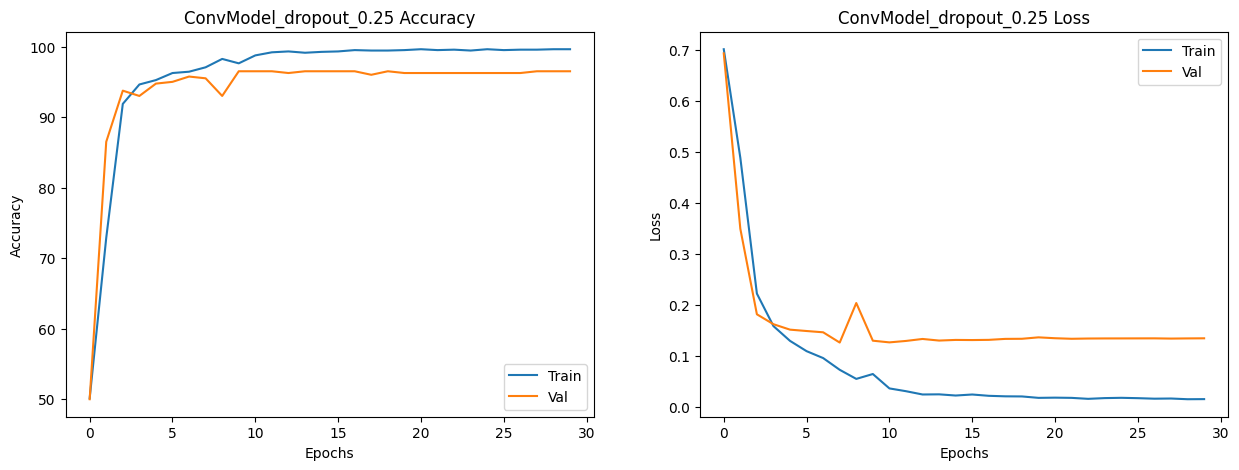

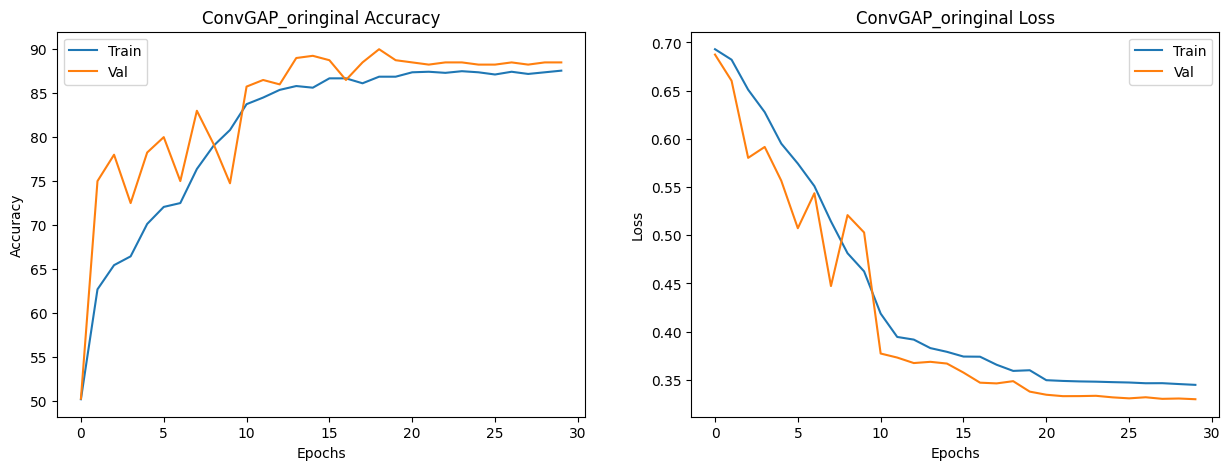

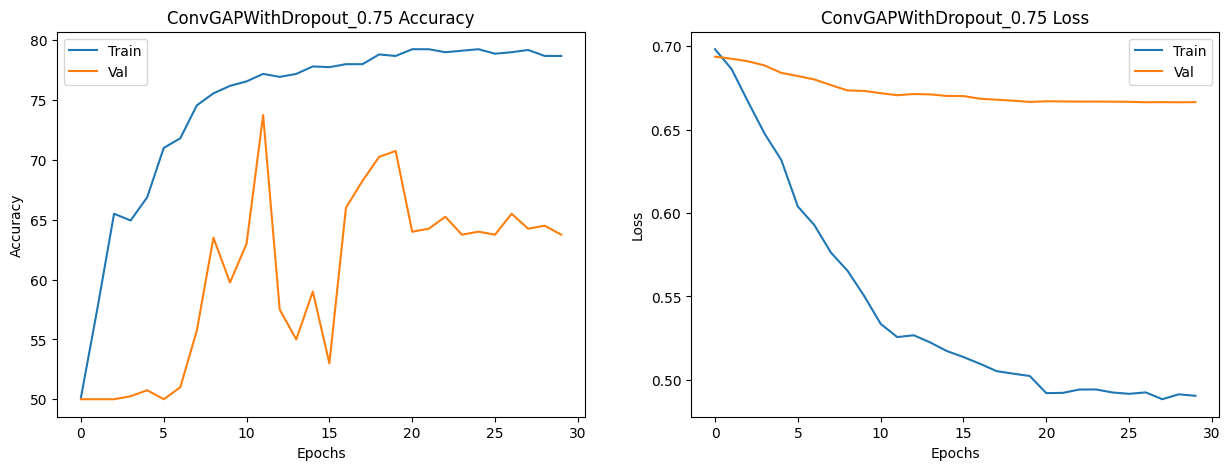

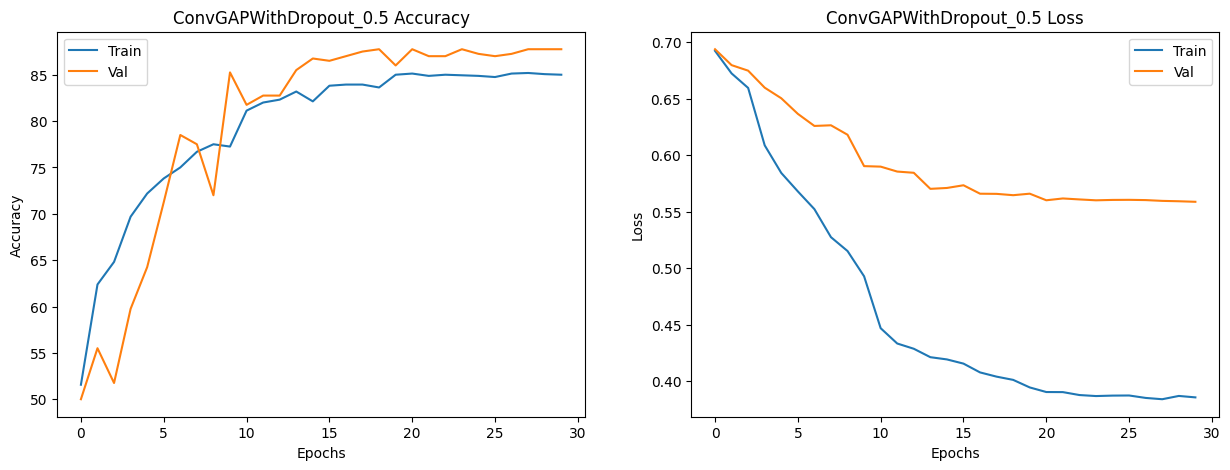

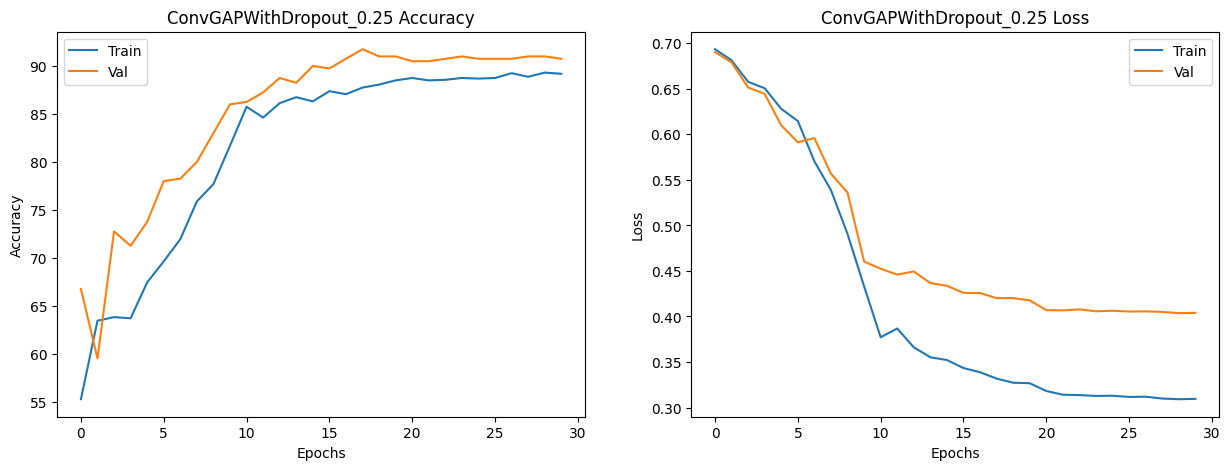

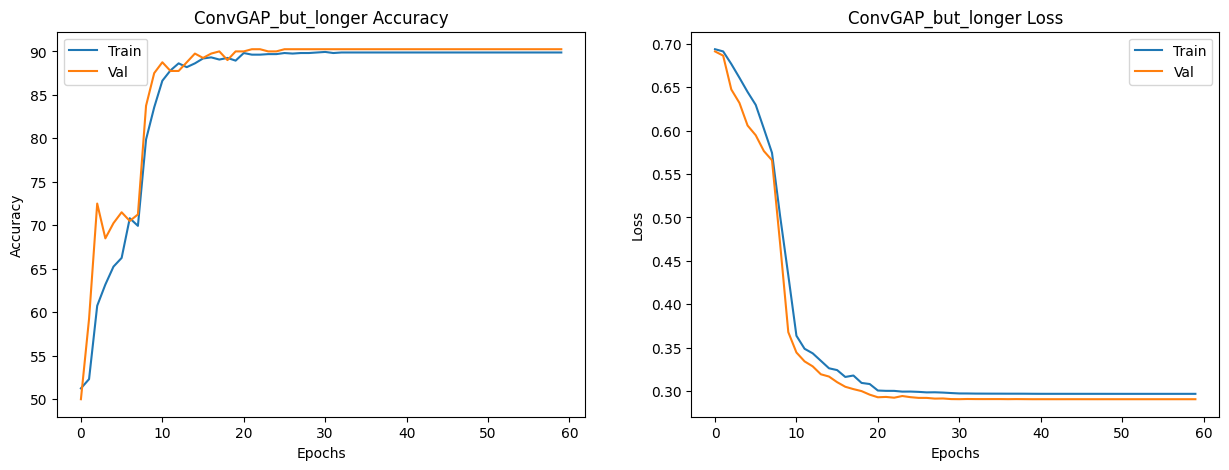

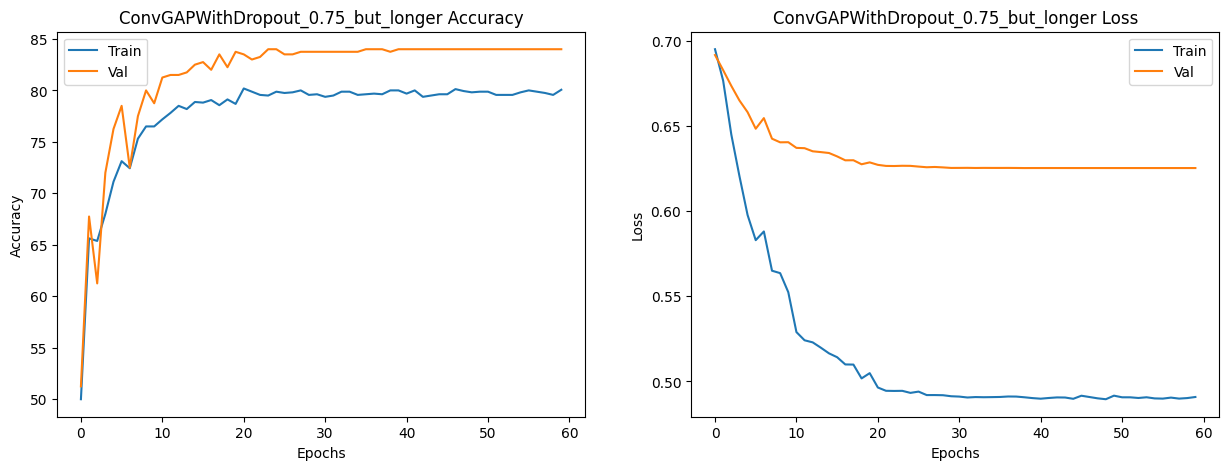

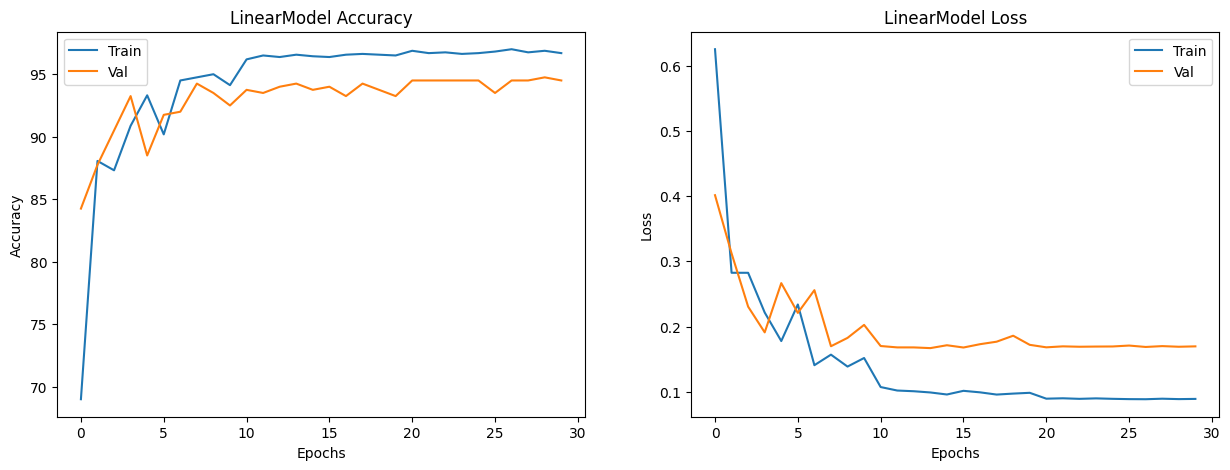

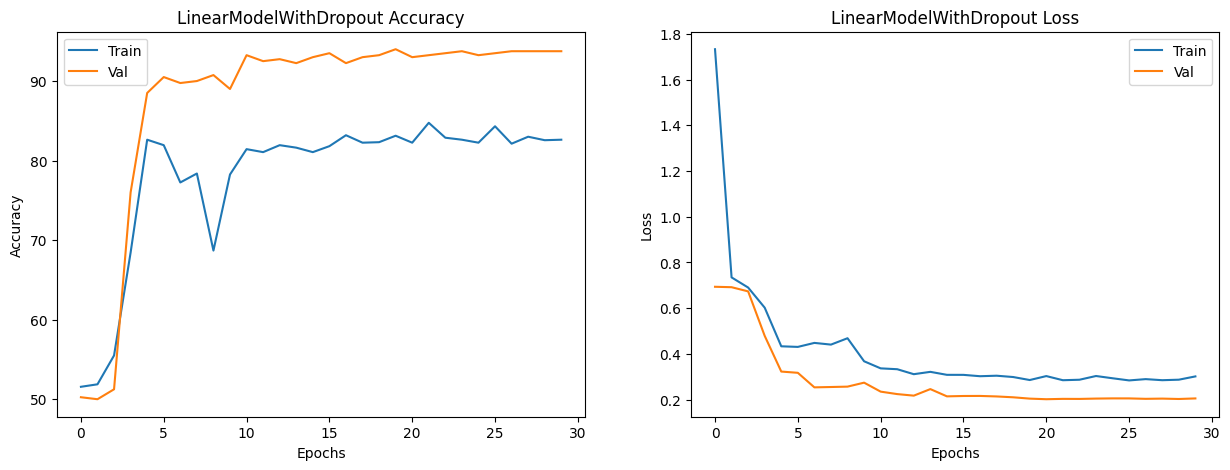

In [ ]:
model_name_list = ['ConvModel_oringinal',"ConvModel_dropout_0.5", "ConvModel_dropout_0.75", "ConvModel_dropout_0.25",
                   'ConvGAP_oringinal', "ConvGAPWithDropout_0.75", "ConvGAPWithDropout_0.5", "ConvGAPWithDropout_0.25",
                   "ConvGAP_but_longer", "ConvGAPWithDropout_0.75_but_longer",
                   'LinearModel', "LinearModelWithDropout"]

model_root_path = f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW3/Model"
weight_list, existing_model_list = md_data.read_data(model_name_list, model_root_path, mode="wm")
md_data.compare_images(existing_model_list)

In [ ]:
existing_model_list[0][0]

{'name': 'ConvModel_oringinal',
 'dataset_name': ['https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy',
  'https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy'],
 'train_losses': [0.5937306168675422,
  0.18715818993747235,
  0.12077320706099272],
 'val_losses': [0.2895794499378938, 0.1507021079842861, 0.16000591440556142],
 'train_accuracies': [66.5625, 92.6875, 94.8125],
 'val_accuracies': [87.5, 93.75, 92.5],
 'traning_times': ['2023-10-27 05:31:52.220812',
  '2023-10-27 05:31:54.641266',
  '2023-10-27 05:31:57.018646'],
 'model': 'ConvModel(\n  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)\n  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1

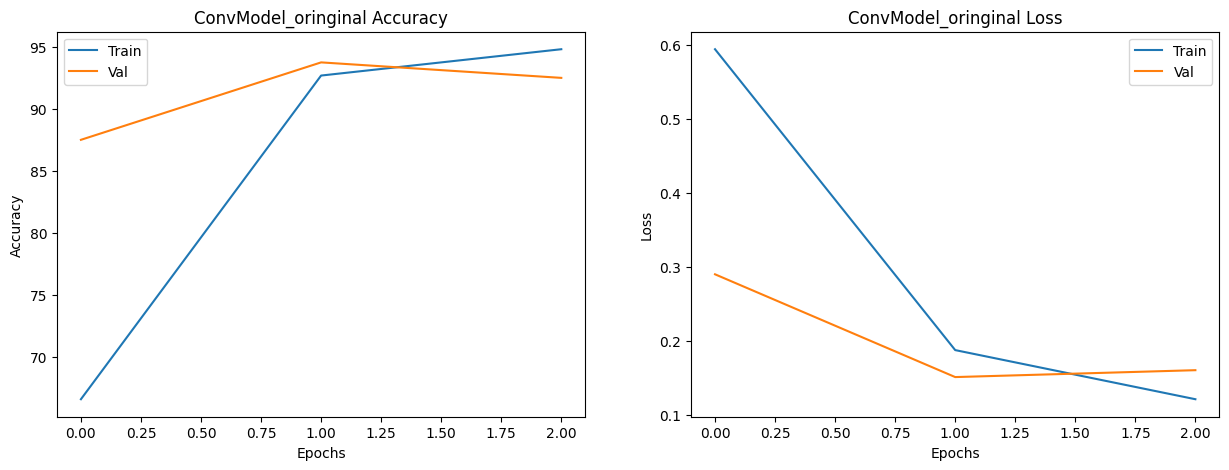

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plotting training and validation accuracy
ax[0].plot(existing_model_list[0][0]["train_accuracies"])
ax[0].plot(existing_model_list[0][0]["val_accuracies"])
ax[0].set_title(f'{existing_model_list[0][0]["name"]} Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])
# Plotting training and validation loss
ax[1].plot(existing_model_list[0][0]["train_losses"])
ax[1].plot(existing_model_list[0][0]["val_losses"])
ax[1].set_title(f'{existing_model_list[0][0]["name"]} Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])
plt.show()